# Data Preparation

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from itertools import combinations
import random
import re
from gensim.utils import tokenize
from sklearn.model_selection import train_test_split

In [2]:
sns.set_theme(context='paper', style='white', palette='deep', rc={'figure.figsize':(12, 10)})

In [3]:
df = pd.read_csv('../data/raw-data/lyrics_data.csv')
df.head()

,ALink,SName,SLink,Lyric,language
0,/ivete-sangalo/,Arerê,/ivete-sangalo/arere.html,"Tudo o que eu quero nessa vida,\nToda vida, é\...",pt
1,/ivete-sangalo/,Se Eu Não Te Amasse Tanto Assim,/ivete-sangalo/se-eu-nao-te-amasse-tanto-assim...,Meu coração\nSem direção\nVoando só por voar\n...,pt
2,/ivete-sangalo/,Céu da Boca,/ivete-sangalo/chupa-toda.html,É de babaixá!\nÉ de balacubaca!\nÉ de babaixá!...,pt
3,/ivete-sangalo/,Quando A Chuva Passar,/ivete-sangalo/quando-a-chuva-passar.html,Quando a chuva passar\n\nPra quê falar\nSe voc...,pt
4,/ivete-sangalo/,Sorte Grande,/ivete-sangalo/sorte-grande.html,A minha sorte grande foi você cair do céu\nMin...,pt


In [4]:
df.shape

(379931, 5)

In [5]:
df_art = pd.read_csv('../data/raw-data/artists_data.csv')
df_art.head()

,Artist,Genres,Songs,Popularity,Link
0,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,/ivete-sangalo/
1,Chiclete com Banana,Axé,268.0,3.8,/chiclete-com-banana/
2,Banda Eva,Axé; Romântico; Reggae,215.0,2.3,/banda-eva/
3,É O Tchan,Axé,129.0,1.6,/e-o-tchan/
4,Claudia Leitte,Pop; Axé; Romântico,167.0,1.5,/claudia-leitte/


In [6]:
df_art.shape

(4168, 5)

In [7]:
# Get only lyrics in English
df = df[df['language']=='en'].reset_index(drop=True)

## Genre

In [8]:
genres = []
for artist_id in df['ALink']:
    # Get the row corresponding to the artist
    artist_row = df_art[df_art['Link']==artist_id].reset_index()
    try:
        # Get all genres from that artist
        genres_in_artist = artist_row['Genres'][0].split('; ')        
    except:
        genres_in_artist = []
    genres.append(genres_in_artist)

In [9]:
df = df.drop(columns = ['ALink', 'SName', 'SLink', 'language'])
df = df.rename(columns={'Lyric': 'lyrics'})

In [10]:
genres = pd.Series(genres)
mlb = MultiLabelBinarizer()
df_genre = pd.DataFrame(mlb.fit_transform(genres), 
                        columns=mlb.classes_,
                        index=genres.index)
df_genre.head()

,Axé,Black Music,Blues,Bossa Nova,COLETÂNEA,Chillout,Classic Rock,Clássico,Country,Dance,...,Soul Music,Surf Music,Tecnopop,Trance,Trap,Trilha Sonora,Trip-Hop,Tropical House,Velha Guarda,World Music
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
df0 = pd.concat([df, df_genre], axis=1)
df0.to_csv('../data/raw-data/lyrics_raw.csv', index=False)

In [12]:
df_genre.sum(axis=1).describe()

count    191814.000000
mean          2.311077
std           0.827677
min           0.000000
25%           2.000000
50%           3.000000
75%           3.000000
max           4.000000
dtype: float64

In [13]:
df_genre.sum().sort_values(ascending=False)[:20]

Rock                63717
Pop                 33571
Pop/Rock            26360
Heavy Metal         21759
Hip Hop             20902
Indie               20134
Romântico           17947
Hard Rock           17250
Rap                 17114
R&B                 15581
Rock Alternativo    13061
Black Music         13024
Dance               11895
Folk                11124
Country             10630
Punk Rock            9215
Soul Music           8131
Electronica          7799
Gospel/Religioso     7337
Hardcore             7082
dtype: int64

In [14]:
df_genre[df_genre.sum(axis=1)==1].sum().sort_values(ascending=False)[:20]

Country             4774
Rock                4672
Heavy Metal         4394
Indie               4289
Pop                 2544
Rap                 2012
Gospel/Religioso    1431
Pop/Rock            1374
Jazz                1356
Punk Rock           1310
Reggae              1255
Hip Hop             1112
Folk                1078
Blues               1063
Soft Rock           1003
Electronica          911
Romântico            829
Hard Rock            739
Trilha Sonora        647
Rockabilly           639
dtype: int64

In [15]:
genres2keep = ['Rock', 'Pop', 'Rap']

df_genre['genre'] = df_genre.apply(
    lambda x: x[genres2keep].idxmax() if x[genres2keep].sum() == 1 and x[genres2keep].max() == 1 else None, axis=1)

In [16]:
df_genre['genre'].value_counts()

Rock    60488
Pop     29163
Rap     15053
Name: genre, dtype: int64

In [17]:
df_genre['genre'].isna().sum()

87110

In [18]:
df_genre['genre'] = df_genre['genre'].str.lower()
df_genre['genre'].unique()

array(['pop', None, 'rap', 'rock'], dtype=object)

In [19]:
df = pd.concat([df, df_genre], axis=1)

In [20]:
df = df.drop(columns=genres2keep)
df = df.dropna()
df = df.reset_index(drop=True)

In [21]:
dummy_cols = [col for col in df.columns if col not in ['lyrics','genre']]

df_subgenre = df.groupby('genre')[dummy_cols].sum().T
df_subgenre

genre,pop,rap,rock
Axé,32,88,105
Black Music,1094,5956,0
Blues,142,65,2712
Bossa Nova,3,0,0
COLETÂNEA,53,0,11
...,...,...,...
Trilha Sonora,1903,1,735
Trip-Hop,196,56,0
Tropical House,0,0,0
Velha Guarda,0,0,0


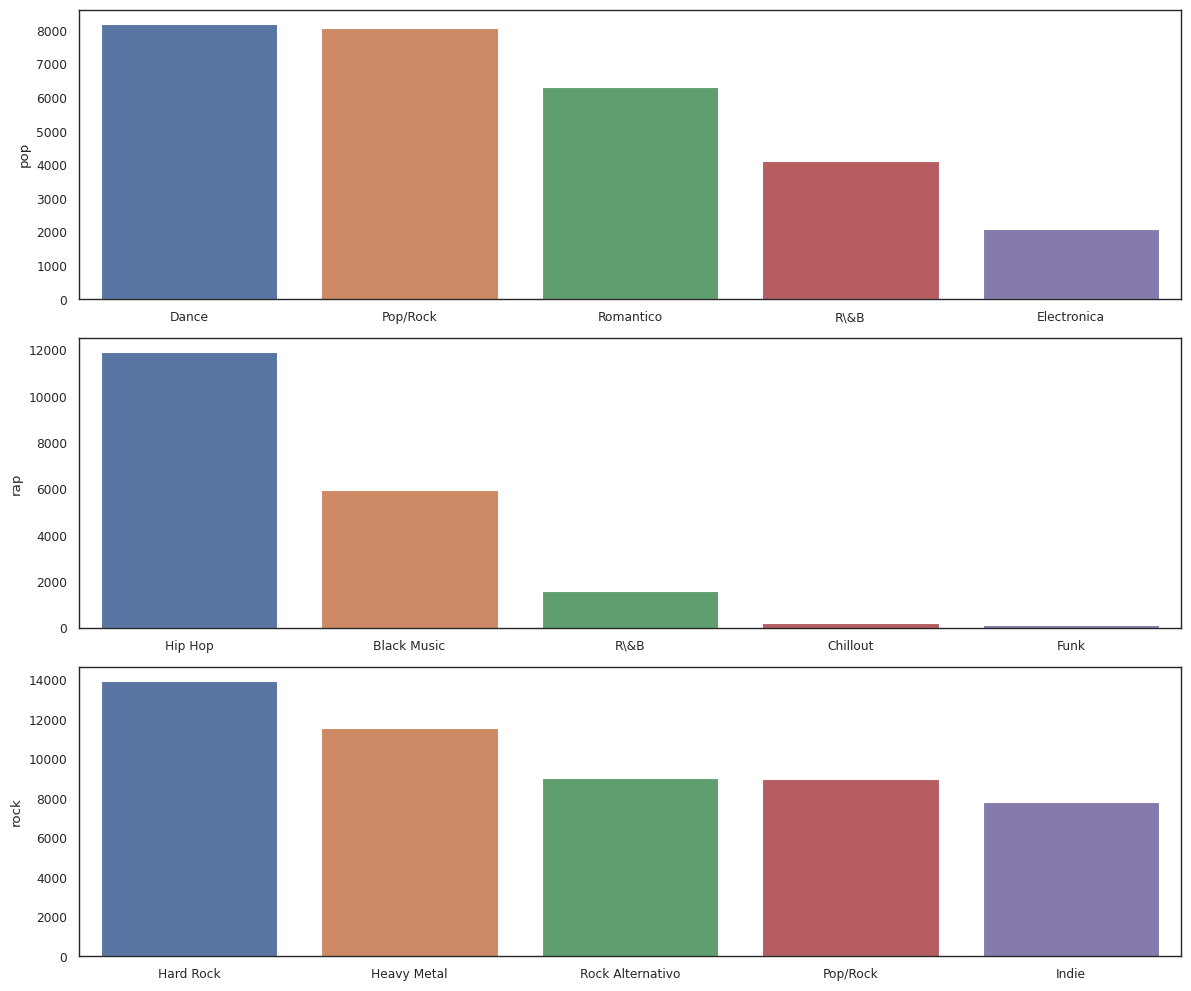

In [22]:
fig, axs = plt.subplots(len(df_subgenre.columns))

for i, genre in enumerate(df_subgenre.columns):    
    bars2plot = df_subgenre[genre].sort_values(ascending=False)[:5]
    bars2plot.index = bars2plot.index.str.replace('â', 'a')
    bars2plot.index = bars2plot.index.str.replace('&', '\&')
    sns.barplot(x=bars2plot.index, y=bars2plot.values, ax=axs[i])    
    axs[i].set_ylabel(genre)    

#fig.suptitle('Top 5 subgenres by genre')
plt.tight_layout()

plt.savefig('../pgf/bar_subgenres.pgf', backend='pgf')

In [23]:
stats_by_genre = [df[df['genre']==genre][dummy_cols].sum(
    axis=1).describe() for genre in df['genre'].unique()]

stats_by_genre = pd.concat(stats_by_genre, axis=1)
stats_by_genre.columns = df['genre'].unique()
stats_by_genre                                             


,pop,rap,rock
count,29163.000000,15053.000000,60488.000000
mean,1.581353,1.390819,1.628951
std,0.649229,0.710940,0.623072
min,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000
50%,2.000000,2.000000,2.000000
75%,2.000000,2.000000,2.000000
max,3.000000,2.000000,3.000000


In [24]:
df = df.drop(columns=dummy_cols)

## Text Cleaning

In [25]:
# Duplicates are songs with multiple artists (e.g. a featuring)
# Remove duplicates having the same genre
print(f'Duplicates with the same genre: {df.duplicated().sum()}')
df = df.drop_duplicates()
# Remove lyrics with different genres among duplicates:
print(f'Duplicates with different genres: {df.duplicated(subset="lyrics").sum()}')
df = df.drop_duplicates(subset="lyrics", keep=False)

Duplicates with the same genre: 626
Duplicates with different genres: 163


In [26]:
random_lyrics = random.choice(df['lyrics'])
random_lyrics

'You sucked religion from my life\nWhen we met I believed you were hell\ntake the knife from my back\nI know you’ll use it again\nDon’t Think Of Me\nI won’t think of you\nDon’t Think Of Me\nI won’t think of you\nYou don’t give\nYou just take\nYou don’t give\nYou just break\n\nWe were never friends\na one act play\nI had to stop pretending\nMy heart don’t ache since you’ve been gone\nIt’s like you never left\nDon’t Think Of Me\nI won’t think of you\nDon’t Think Of Me\nI won’t think of you\nYou don’t give\nYou just take\nYou don’t give\nYou just take\n\nMy time and my money but money ain’t love no\nThe evil within shines without a light\nI know what I see and I mean what I say'

In [27]:
def clean_text(lyrics):
    lyrics = re.sub(r'\((.+?)?\)', '', lyrics)
    lyrics = re.sub(r'\[(.+?)?\]', '', lyrics)
    lyrics = re.sub(r'\{(.+?)?\}', '', lyrics)
    lyrics = re.sub(r'\n+', '\n', lyrics)
    lyrics = re.sub(r'^[^a-zA-Z]+$', '', lyrics, flags=re.MULTILINE)
    return lyrics

In [28]:
clean_text(random_lyrics)

'You sucked religion from my life\nWhen we met I believed you were hell\ntake the knife from my back\nI know you’ll use it again\nDon’t Think Of Me\nI won’t think of you\nDon’t Think Of Me\nI won’t think of you\nYou don’t give\nYou just take\nYou don’t give\nYou just break\nWe were never friends\na one act play\nI had to stop pretending\nMy heart don’t ache since you’ve been gone\nIt’s like you never left\nDon’t Think Of Me\nI won’t think of you\nDon’t Think Of Me\nI won’t think of you\nYou don’t give\nYou just take\nYou don’t give\nYou just take\nMy time and my money but money ain’t love no\nThe evil within shines without a light\nI know what I see and I mean what I say'

In [29]:
df['lyrics'] = df['lyrics'].apply(clean_text)

In [30]:
# Split lyrics in verses consider \n as sep, filter empty element in list (it's the result of '\n\n' or spaces)
df['lyrics'] = df['lyrics'].apply(
    lambda x: [verse for verse in x.split('\n') if verse.strip()])

In [31]:
# Count number of verses
df['verses'] = df['lyrics'].apply(len)

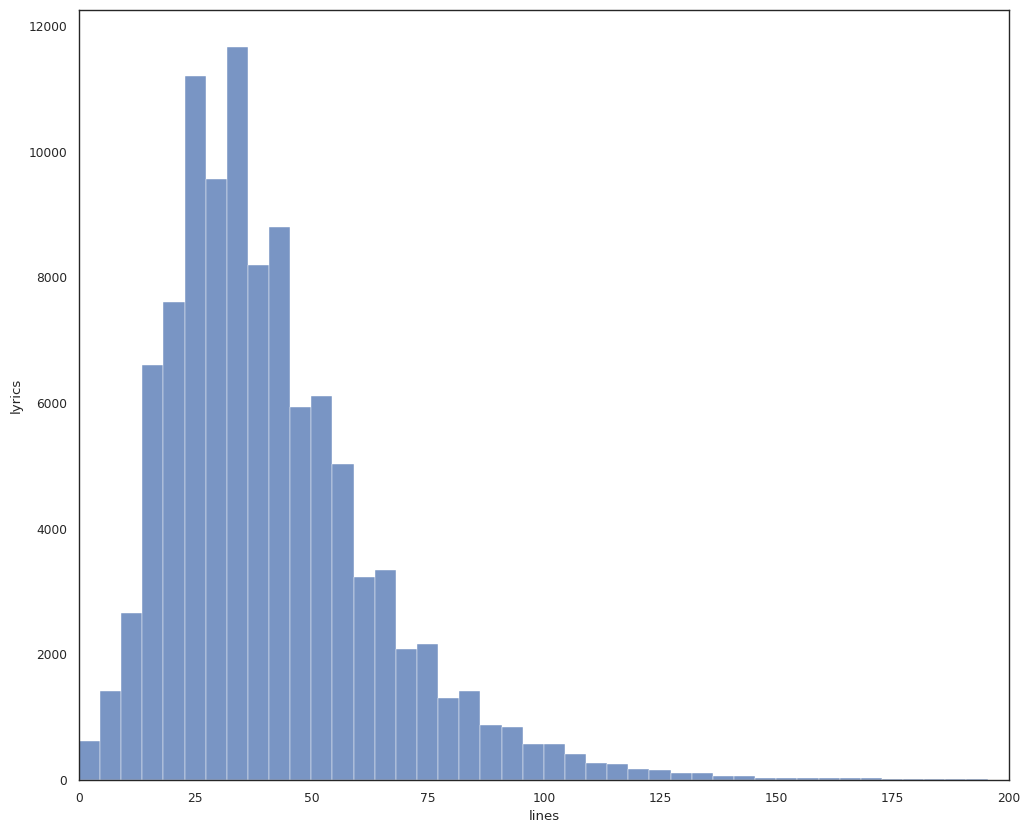

In [32]:
fig, ax = plt.subplots()
ax = sns.histplot(data=df, x='verses', bins=200)
ax.set_xlabel('lines')
ax.set_ylabel('lyrics')
#ax.set_title('Lyrics by number of verses')
ax.set_xlim([0, 200])
plt.savefig('../pgf/hist_lyrics_verses.pgf', backend='pgf')

In [33]:
df.shape

(103752, 3)

## Outlier Detection

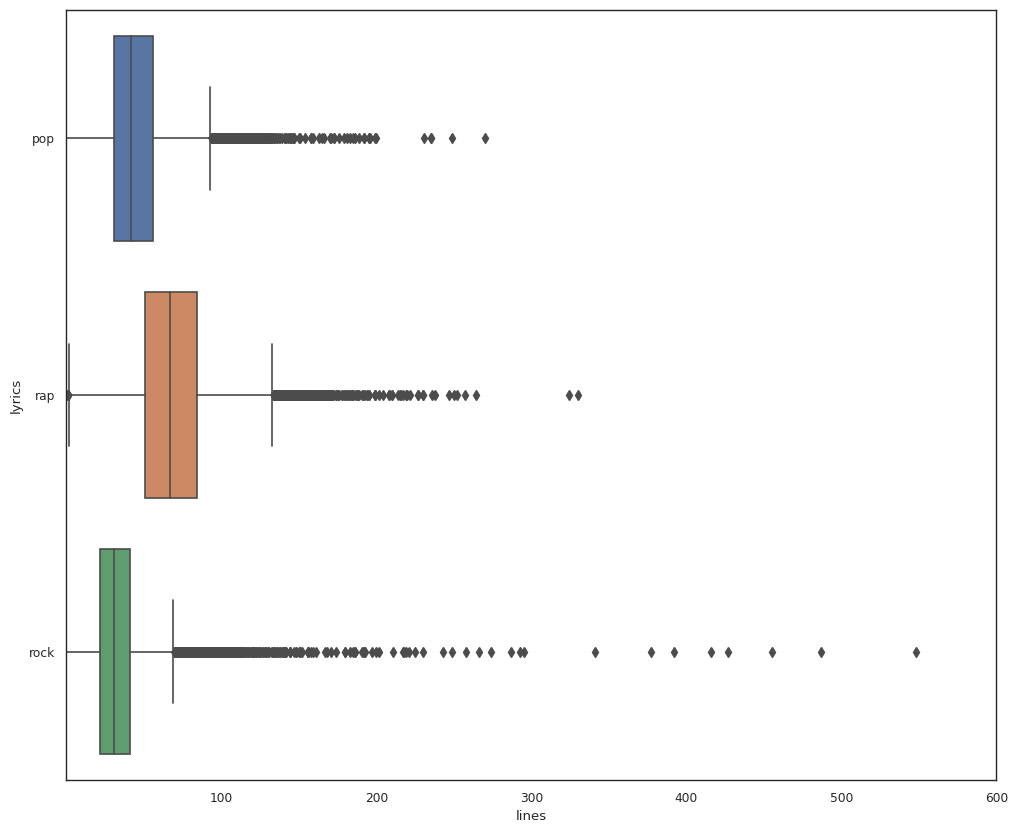

In [34]:
fig, ax = plt.subplots()
ax = sns.boxplot(data=df, x='verses', y='genre')
ax.set_xlabel('lines')
ax.set_ylabel('lyrics')
#ax.set_title('Lyrics by number of verses')
ax.set_xticks(range(100, 1001, 100))
ax.set_xlim([0, 600])
plt.savefig('../pgf/box_lyrics_lines.pgf', backend='pgf')

In [35]:
# Drop the outlier rows from the DataFrame
df = df.drop(df[df['verses'] > 130].index)
df = df.drop(df[df['verses'] < 20].index)

In [36]:
df = df.drop(columns=['verses'])

In [37]:
lyrics_by_verse = zip(list(df['lyrics']),list(df['genre']),list(df.index))

verses_by_genre = [(verse, genre, index) for lyrics, genre, index in lyrics_by_verse for verse in lyrics]

df_verse = pd.DataFrame(verses_by_genre, columns=['verse','genre','index'])

df_verse.head()

,verse,genre,index
0,I feel so unsure,pop,0
1,As I take your hand and lead you to the dance ...,pop,0
2,"As the music dies, something in your eyes",pop,0
3,Calls to mind a silver screen,pop,0
4,And all those sad goodbyes,pop,0


In [38]:
df_verse['tokens'] = df_verse['verse'].apply(lambda x: len(list(tokenize(x))))

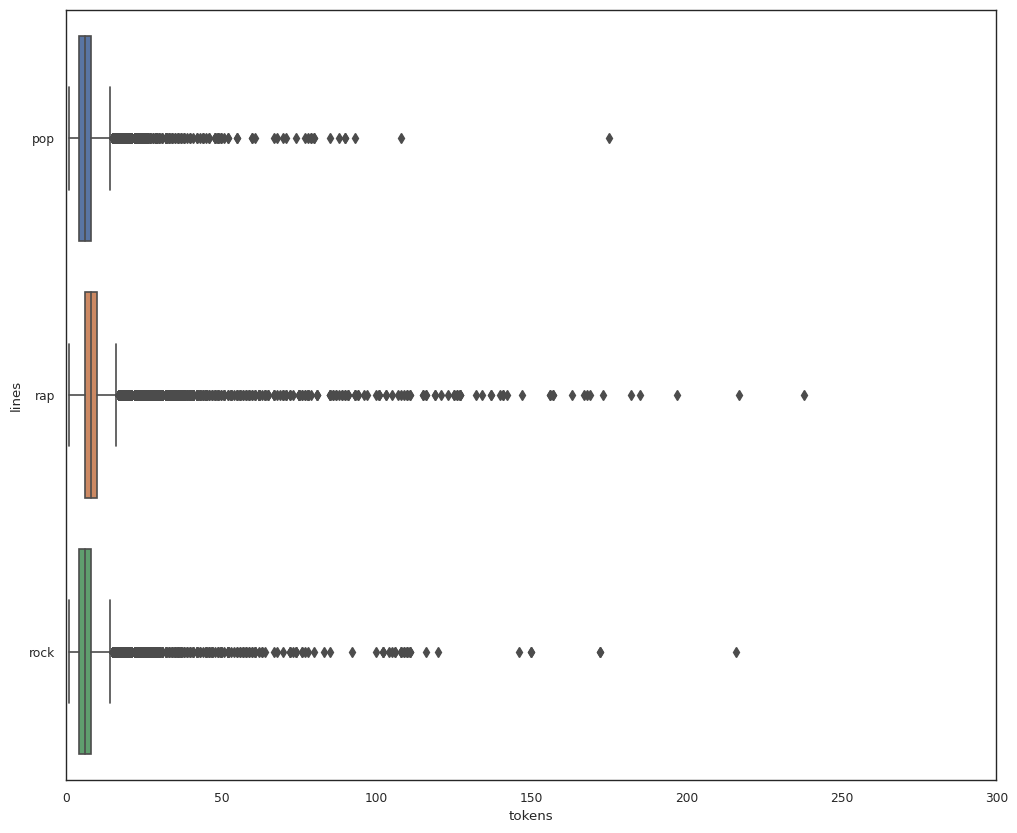

In [39]:
fig, ax = plt.subplots()
ax = sns.boxplot(data=df_verse, x='tokens', y='genre')
ax.set_xlabel('tokens')
ax.set_ylabel('lines')
ax.set_xlim([0, 300])
plt.savefig('../pgf/box_lines_tokens.pgf', backend='pgf')

In [40]:
# Compute the IQR for each genre
grouped = df_verse.groupby('genre')
# Compute IQR for each group
iqr = grouped.apply(lambda x: x['tokens'].quantile(0.75) - x['tokens'].quantile(0.25))
# Compute upper bounds for each group
upper_bound = grouped.apply(lambda x: x['tokens'].quantile(0.75) + 2 * iqr[x.name])
# Reset the index of the upper_bound series to match the labels of the grouped DataFrame
#upper_bound = upper_bound
# Mark outliers
df_verse['outlier'] = np.where(df_verse['tokens'] > upper_bound[df_verse['genre']].values, True, False)
# Get the index values of the outlier rows
outlier_index = df_verse[df_verse['outlier'] == True]['index'].unique()

print(f'Number of outliers: {len(outlier_index)}\n')

print('Upper bound:\n')
print(upper_bound)

Number of outliers: 3959

Upper bound:

genre
pop     16.0
rap     18.0
rock    16.0
dtype: float64


In [41]:
df = df.drop(outlier_index)
df = df.reset_index(drop=True)

In [42]:
df['genre'].value_counts(normalize=True)

rock    0.553998
pop     0.299019
rap     0.146984
Name: genre, dtype: float64

In [43]:
df['genre'].value_counts()

rock    47815
pop     25808
rap     12686
Name: genre, dtype: int64

In [44]:
df = df.groupby('genre').sample(n=12000, random_state=42).reset_index(drop=True)

In [45]:
df = df.reset_index(drop=True)
# Keep original index as id incase we want to retrieve samples in original df
df['id'] = df.index

In [46]:
df.head()

,lyrics,genre,id
0,"[So long, My sweet love, I miss you, More than...",pop,0
1,"[It won't be long before I'm leaving here, The...",pop,1
2,"[Are we crazy?, Living our lives through a len...",pop,2
3,"[When did it go wrong, I will never know, I ha...",pop,3
4,"[I've waited all this time, Counting minutes a...",pop,4


In [47]:
"""
df.to_csv('../data/lyrics.csv', index=False)
"""

"\ndf.to_csv('../data/lyrics.csv', index=False)\n"